In [1]:
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Reshape
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras import metrics
import os
import re
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

## Loading data

In [11]:
#loading all data into correct format

def load_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224)) #Input shape will change once images are processed
    img_array = np.array(img)
    return img_array

#pathnames
train_file = 'archive/train_annotations'
valid_file = 'archive/valid_annotations'
augmented_annotations = '5k_augmented_train_annotation.txt'


train_labels = []
train_images = []
train_image_file = []
val_labels = []
val_images = []

#adding original image train labels
with open(train_file, "r") as f:
    for line in f:
        category_ids = re.findall(r'"category_id": [1,2]', line)
    for id in category_ids:
        train_labels.append(int(id[-1]) - 1)

#adding original train images
for file in sorted(os.listdir('./archive/train/train/')):
    train_image_file.append(file)
    img_path = os.path.join('./archive/train/train/', file)   
    img = load_image(img_path)
    train_images.append(img)

#adding augmented train labels  
with open(augmented_annotations, "r") as f:
    content = f.read()
    aug_category_ids = re.findall(r'"augmented_\d+\.jpg","category_id":[1,2]', content)
    #making a list of all augmented image file names for next step
    img_files = re.findall(r'augmented_\d+\.jpg', content)
    for id in aug_category_ids:
        train_labels.append(int(id[-1]) - 1)

#adding augmented image files
for file in img_files:
    train_image_file.append(file)
    img_path = os.path.join('5k_train', file)   
    img = load_image(img_path)
    train_images.append(img)

#adding validation labels
with open(valid_file, "r") as f:
    for line in f:
        category_ids = re.findall(r'"category_id": [1,2]', line)
    for id in category_ids:
        val_labels.append(int(id[-1]) - 1)

#adding validation images
for file in sorted(os.listdir('./archive/valid/valid/')):
    img_path = os.path.join('./archive/valid/valid/', file)   
    img = load_image(img_path)
    val_images.append(img)

#numpy arrays of images and labels for both sets
train_images = np.array(train_images)
val_images = np.array(val_images)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

#Normalize
train_images = train_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0

## Image augmentation

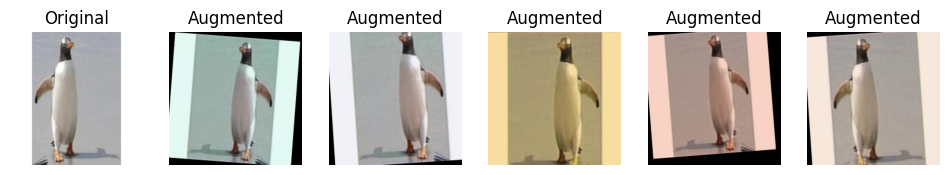

In [3]:
#plotting original and augemnted images
fig, axes = plt.subplots(1, 6, figsize=(12, 4))

axes[0].imshow(train_images[0])
axes[0].axis('off')
axes[0].set_title(f'Original')
for i in range(1,6):
    axes[i].imshow(train_images[i + 499])
    axes[i].axis('off') 
    axes[i].set_title(f'Augmented')

plt.show()

### Evaluation metrics

In [4]:
def evaluation(model):
    val_predictions = model.predict(val_images)
    val_binary_predictions = (val_predictions > 0.5).astype(int)
    # Calculate all evaluation metrics
    conf_matrix = tf.math.confusion_matrix(val_labels, val_binary_predictions)
    accuracy = metrics.Accuracy()(val_labels, val_binary_predictions)
    precision = metrics.Precision()(val_labels, val_binary_predictions)
    recall = metrics.Recall()(val_labels, val_binary_predictions)
    f1 = 2 * (precision * recall) / (precision + recall)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Accuracy", accuracy.numpy())
    print("Precision:", precision.numpy())
    print("Recall:", recall.numpy())
    print("F1 Score:", f1.numpy())

## VGG16 model

<img src="https://miro.medium.com/v2/resize:fit:1400/0*0M8CobXpNwFDCmOQ" art="vgg_image" width='600'/>

image from https://miro.medium.com/v2/resize:fit:1400/0*0M8CobXpNwFDCmOQ

In [5]:
#Getting pretrained VGG16 model
input_shape = (224, 224, 3)
baseModel = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
#Freezing pretrained model layers
baseModel.trainable = False

In [6]:
#building VGG16 model with new layers on the end to make it binary
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr = 5e-4
initial_model = keras.Sequential()
initial_model.add(baseModel)
initial_model.add(keras.layers.Flatten())
initial_model.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
initial_model.add(keras.layers.Dropout(0.3))
initial_model.add(keras.layers.Dense(1, activation='sigmoid'))
initial_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["accuracy"])
#training
history = initial_model.fit(train_images, train_labels, batch_size=32, epochs=8, validation_data=(val_images, val_labels))

Epoch 1/10
172/172 [==============================] - 372s 2s/step - loss: 1.2420 - accuracy: 0.9035 - val_loss: 0.8024 - val_accuracy: 0.8333
Epoch 2/10
172/172 [==============================] - 371s 2s/step - loss: 0.2798 - accuracy: 0.9775 - val_loss: 0.3300 - val_accuracy: 0.9167
Epoch 3/10
172/172 [==============================] - 366s 2s/step - loss: 0.2039 - accuracy: 0.9756 - val_loss: 0.3323 - val_accuracy: 0.9306
Epoch 4/10
172/172 [==============================] - 386s 2s/step - loss: 0.1558 - accuracy: 0.9864 - val_loss: 0.3591 - val_accuracy: 0.9306
Epoch 5/10
172/172 [==============================] - 376s 2s/step - loss: 0.1990 - accuracy: 0.9675 - val_loss: 0.5558 - val_accuracy: 0.8611
Epoch 6/10
172/172 [==============================] - 380s 2s/step - loss: 0.1760 - accuracy: 0.9749 - val_loss: 0.3551 - val_accuracy: 0.9028
Epoch 7/10
172/172 [==============================] - 384s 2s/step - loss: 0.1470 - accuracy: 0.9820 - val_loss: 0.4520 - val_accuracy: 0.8889

## VGG16 evaluation

In [7]:
evaluation(initial_model)

3/3 [==============================] - 5s 1s/step
Confusion Matrix:
tf.Tensor(
[[31  5]
 [ 2 34]], shape=(2, 2), dtype=int32)
Accuracy 0.9027778
Precision: 0.8717949
Recall: 0.9444444
F1 Score: 0.90666664


## VGG16 with self-attention

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*LUE23j9u__ch3b8nTR5_wA.png" art="vgg_image" width='600'/>

image from https://miro.medium.com/v2/resize:fit:720/format:webp/1*LUE23j9u__ch3b8nTR5_wA.png

In [13]:
#Custom VGG16 model with added attention layer and binary output

class AttentionVGG(keras.models.Model):
    def __init__(self, input_shape):
        super(AttentionVGG, self).__init__()
        #taking base model from VGG16 and freezing layers
        self.baseModel = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
        self.baseModel.trainable = False
        
        # attention layer
        self.attention_layer = tf.keras.layers.Attention(use_scale=True)
        # fully connected layers with dropout added
        self.flatten = Flatten()
        self.dense1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))
        self.dropout = Dropout(0.4)
        self.dense2 = Dense(1, activation='sigmoid')

    
    def call(self, inputs):
        x = self.baseModel(inputs)
        x = self.attention_layer([x, x])
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        output = self.dense2(x)
        return output
    

In [14]:
input_shape = (224, 224, 3)
#Initialising custom model
att_model = AttentionVGG(input_shape=input_shape)
x = Input(shape=(224, 224, 3))
attn_model = keras.models.Model(inputs=[x], outputs = att_model.call(x))

lr = 5e-4
attn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["accuracy"])

In [15]:
#training
history = attn_model.fit(train_images, train_labels, batch_size=32, epochs=8, validation_data=(val_images, val_labels))

Epoch 1/8
172/172 [==============================] - 376s 2s/step - loss: 1.2130 - accuracy: 0.9107 - val_loss: 0.5635 - val_accuracy: 0.9028
Epoch 2/8
172/172 [==============================] - 374s 2s/step - loss: 0.2785 - accuracy: 0.9713 - val_loss: 0.3260 - val_accuracy: 0.9167
Epoch 3/8
172/172 [==============================] - 372s 2s/step - loss: 0.1973 - accuracy: 0.9760 - val_loss: 0.3704 - val_accuracy: 0.9167
Epoch 4/8
172/172 [==============================] - 374s 2s/step - loss: 0.1809 - accuracy: 0.9753 - val_loss: 0.3072 - val_accuracy: 0.8889
Epoch 5/8
172/172 [==============================] - 380s 2s/step - loss: 0.1671 - accuracy: 0.9787 - val_loss: 0.5657 - val_accuracy: 0.8750
Epoch 6/8
172/172 [==============================] - 375s 2s/step - loss: 0.1615 - accuracy: 0.9780 - val_loss: 0.5183 - val_accuracy: 0.9028
Epoch 7/8
141/172 [=======================>......] - ETA: 1:07 - loss: 0.1873 - accuracy: 0.9690

## Self-attention model evaluation

In [ ]:
evaluation(attn_model)

3/3 [==============================] - 5s 1s/step
Confusion Matrix:
tf.Tensor(
[[30  6]
 [ 2 34]], shape=(2, 2), dtype=int32)
Accuracy 0.8888889
Precision: 0.85
Recall: 0.9444444
F1 Score: 0.8947368


## VGG16 with channel attention

<img src="https://miro.medium.com/v2/resize:fit:1400/0*WNEGJaXOZrNLtSv7" art="vgg_image" width='600'/>

image from https://miro.medium.com/v2/resize:fit:1400/0*WNEGJaXOZrNLtSv7

In [ ]:
#Code from https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb
class ChannelAttention(tf.keras.layers.Layer):
  def __init__(self, filters, ratio):
    super(ChannelAttention, self).__init__()
    self.filters = filters
    self.ratio = ratio

  def build(self, input_shape):
    self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                                activation='relu', kernel_initializer='he_normal', 
                                use_bias=True, 
                                bias_initializer='zeros')
    self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                                kernel_initializer='he_normal',
                                use_bias=True,
                                bias_initializer='zeros')

  def call(self, inputs):
    # AvgPool
    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)


    avg_pool = self.shared_layer_one(avg_pool)
    avg_pool = self.shared_layer_two(avg_pool)

    # MaxPool
    max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
    max_pool = tf.keras.layers.Reshape((1,1,self.filters))(max_pool)

    max_pool = self.shared_layer_one(max_pool)
    max_pool = self.shared_layer_two(max_pool)


    attention = tf.keras.layers.Add()([avg_pool,max_pool])
    attention = tf.keras.layers.Activation('sigmoid')(attention)

    return tf.keras.layers.Multiply()([inputs, attention])

In [ ]:
#Custom VGG16 model with channel attention

class CAttentionVGG(keras.models.Model):
    def __init__(self, input_shape):
        super(CAttentionVGG, self).__init__()
        #taking base model from VGG16 and freezing layers
        self.baseModel = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
        self.baseModel.trainable = False
        
        # attention layer
        self.channel_attention = ChannelAttention(512, 8)
        # fully connected layers with dropout added
        self.flatten = Flatten()
        self.dense1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))
        self.dropout = Dropout(0.4)
        self.dense2 = Dense(1, activation='sigmoid')

    
    def call(self, inputs):
        x = self.baseModel(inputs)
        x = self.channel_attention(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        output = self.dense2(x)
        return output
    

In [ ]:
input_shape = (224, 224, 3)
#Initialising custom model
cmodel = CAttentionVGG(input_shape=input_shape)
x = Input(shape=(224, 224, 3))
c_model = keras.models.Model(inputs=[x], outputs = cmodel.call(x))

lr = 5e-4
c_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["accuracy"])



In [ ]:
#training
history = c_model.fit(train_images, train_labels, batch_size=32, epochs=8, validation_data=(val_images, val_labels))

Epoch 1/10
94/94 [==============================] - 211s 2s/step - loss: 1.2750 - accuracy: 0.8737 - val_loss: 0.5888 - val_accuracy: 0.9028
Epoch 2/10
94/94 [==============================] - 209s 2s/step - loss: 0.2140 - accuracy: 0.9677 - val_loss: 0.6390 - val_accuracy: 0.9167
Epoch 3/10
94/94 [==============================] - 209s 2s/step - loss: 0.1139 - accuracy: 0.9773 - val_loss: 0.5535 - val_accuracy: 0.9028
Epoch 4/10
94/94 [==============================] - 205s 2s/step - loss: 0.0710 - accuracy: 0.9887 - val_loss: 0.7579 - val_accuracy: 0.9167
Epoch 5/10
94/94 [==============================] - 204s 2s/step - loss: 0.0482 - accuracy: 0.9917 - val_loss: 0.7576 - val_accuracy: 0.8889
Epoch 6/10
94/94 [==============================] - 204s 2s/step - loss: 0.0421 - accuracy: 0.9903 - val_loss: 0.8410 - val_accuracy: 0.9028
Epoch 7/10
94/94 [==============================] - 204s 2s/step - loss: 0.0372 - accuracy: 0.9940 - val_loss: 0.8226 - val_accuracy: 0.9167
Epoch 8/10
94

## Channel attention model evaluation

In [ ]:
evaluation(c_model)

3/3 [==============================] - 5s 1s/step
Confusion Matrix:
tf.Tensor(
[[30  6]
 [ 1 35]], shape=(2, 2), dtype=int32)
Accuracy 0.9027778
Precision: 0.85365856
Recall: 0.9722222
F1 Score: 0.90909094


## VGG16 with spatial attention

In [ ]:
#Code from https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb
class SpatialAttention(tf.keras.layers.Layer):
  def __init__(self, kernel_size):
    super(SpatialAttention, self).__init__()
    self.kernel_size = kernel_size

  def build(self, input_shape):
    self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                      kernel_size=self.kernel_size,
                      strides=1,
                      padding='same',
                      activation='sigmoid',
                      kernel_initializer='he_normal',
                      use_bias=False)

  def call(self, inputs):

  # AvgPool
    avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

    # MaxPool
    max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

    attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

    attention = self.conv2d(attention)


    return tf.keras.layers.multiply([inputs, attention]) 

In [ ]:
#Custom VGG16 model with spatial attention

class SAttentionVGG(keras.models.Model):
    def __init__(self, input_shape):
        super(SAttentionVGG, self).__init__()
        #taking base model from VGG16 and freezing layers
        self.baseModel = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
        self.baseModel.trainable = False
        
        # attention layer
        self.spatial_attention = SpatialAttention(3)
        # fully connected layers with dropout added
        self.flatten = Flatten()
        self.dense1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))
        self.dropout = Dropout(0.4)
        self.dense2 = Dense(1, activation='sigmoid')

    
    def call(self, inputs):
        x = self.baseModel(inputs)
        x = self.spatial_attention(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        output = self.dense2(x)
        return output

In [ ]:
input_shape = (224, 224, 3)
#Initialising custom model
smodel = SAttentionVGG(input_shape=input_shape)
x = Input(shape=(224, 224, 3))
s_model = keras.models.Model(inputs=[x], outputs = smodel.call(x))

lr = 5e-4
s_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["accuracy"])

In [ ]:
#training
history = s_model.fit(train_images, train_labels, batch_size=32, epochs=8, validation_data=(val_images, val_labels))

Epoch 1/10
94/94 [==============================] - 213s 2s/step - loss: 1.2533 - accuracy: 0.8257 - val_loss: 0.4193 - val_accuracy: 0.8889
Epoch 2/10
94/94 [==============================] - 213s 2s/step - loss: 0.2103 - accuracy: 0.9587 - val_loss: 0.4343 - val_accuracy: 0.9167
Epoch 3/10
94/94 [==============================] - 216s 2s/step - loss: 0.1124 - accuracy: 0.9797 - val_loss: 0.4541 - val_accuracy: 0.9028
Epoch 4/10
94/94 [==============================] - 216s 2s/step - loss: 0.0906 - accuracy: 0.9803 - val_loss: 0.5423 - val_accuracy: 0.9167
Epoch 5/10
94/94 [==============================] - 216s 2s/step - loss: 0.0603 - accuracy: 0.9900 - val_loss: 0.5682 - val_accuracy: 0.8750
Epoch 6/10
94/94 [==============================] - 211s 2s/step - loss: 0.0596 - accuracy: 0.9900 - val_loss: 0.6577 - val_accuracy: 0.9028
Epoch 7/10
94/94 [==============================] - 213s 2s/step - loss: 0.0520 - accuracy: 0.9923 - val_loss: 0.7055 - val_accuracy: 0.9028
Epoch 8/10
94

## Spatial attention model evaluation

In [ ]:
evaluation(s_model)

3/3 [==============================] - 5s 1s/step
Confusion Matrix:
tf.Tensor(
[[33  3]
 [ 5 31]], shape=(2, 2), dtype=int32)
Accuracy 0.8888889
Precision: 0.9117647
Recall: 0.8611111
F1 Score: 0.88571423


## VGG16 Convolutional block attention model with both channel and spatial attention

In [ ]:
#Custom VGG16 model with CBAM

class CBAMAttentionVGG(keras.models.Model):
    def __init__(self, input_shape):
        super(CBAMAttentionVGG, self).__init__()
        #taking base model from VGG16 and freezing layers
        self.baseModel = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
        self.baseModel.trainable = False
        
        # attention layer
        self.conv_layer = keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu')
        self.channel_attention = ChannelAttention(512, 8)
        self.spatial_attention = SpatialAttention(3)
        # fully connected layers with dropout added
        self.flatten = Flatten()
        self.dense1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))
        self.dropout = Dropout(0.4)
        self.dense2 = Dense(1, activation='sigmoid')

    
    def call(self, inputs):
        x = self.baseModel(inputs)
        x = self.conv_layer(x)
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        output = self.dense2(x)
        return output
    

In [ ]:
input_shape = (224, 224, 3)
#Initialising custom model
cbammodel = CBAMAttentionVGG(input_shape=input_shape)
x = Input(shape=(224, 224, 3))
cbam_model = keras.models.Model(inputs=[x], outputs = cbammodel.call(x))

lr = 5e-4
cbam_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["accuracy"])

In [ ]:
#training
history = cbam_model.fit(train_images, train_labels, batch_size=32, epochs=8, validation_data=(val_images, val_labels))

Epoch 1/10
94/94 [==============================] - 214s 2s/step - loss: 1.0907 - accuracy: 0.8493 - val_loss: 0.4177 - val_accuracy: 0.9306
Epoch 2/10
94/94 [==============================] - 212s 2s/step - loss: 0.1342 - accuracy: 0.9670 - val_loss: 0.3631 - val_accuracy: 0.9167
Epoch 3/10
94/94 [==============================] - 210s 2s/step - loss: 0.0729 - accuracy: 0.9803 - val_loss: 0.5728 - val_accuracy: 0.9028
Epoch 4/10
94/94 [==============================] - 211s 2s/step - loss: 0.0593 - accuracy: 0.9833 - val_loss: 0.5986 - val_accuracy: 0.8889
Epoch 5/10
94/94 [==============================] - 209s 2s/step - loss: 0.0470 - accuracy: 0.9843 - val_loss: 0.5628 - val_accuracy: 0.9167
Epoch 6/10
94/94 [==============================] - 210s 2s/step - loss: 0.0463 - accuracy: 0.9887 - val_loss: 0.8413 - val_accuracy: 0.8889
Epoch 7/10
94/94 [==============================] - 211s 2s/step - loss: 0.0281 - accuracy: 0.9940 - val_loss: 0.5907 - val_accuracy: 0.8750
Epoch 8/10
94

## CBAM model evaluation

In [ ]:
evaluation(s_model)

3/3 [==============================] - 5s 1s/step
Confusion Matrix:
tf.Tensor(
[[33  3]
 [ 5 31]], shape=(2, 2), dtype=int32)
Accuracy 0.8888889
Precision: 0.9117647
Recall: 0.8611111
F1 Score: 0.88571423


In [ ]:

cbam_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 512)         2359808   
                                                                 
 channel_attention_1 (Chann  (None, 7, 7, 512)         66112     
 elAttention)                                                    
                                                                 
 spatial_attention_2 (Spati  (None, 7, 7, 512)         98        
 alAttention)                                                    
                                                                 
 flatten_9 (Flatten)         (None, 25088)             0   

## Attention visualisation with GRAD CAM

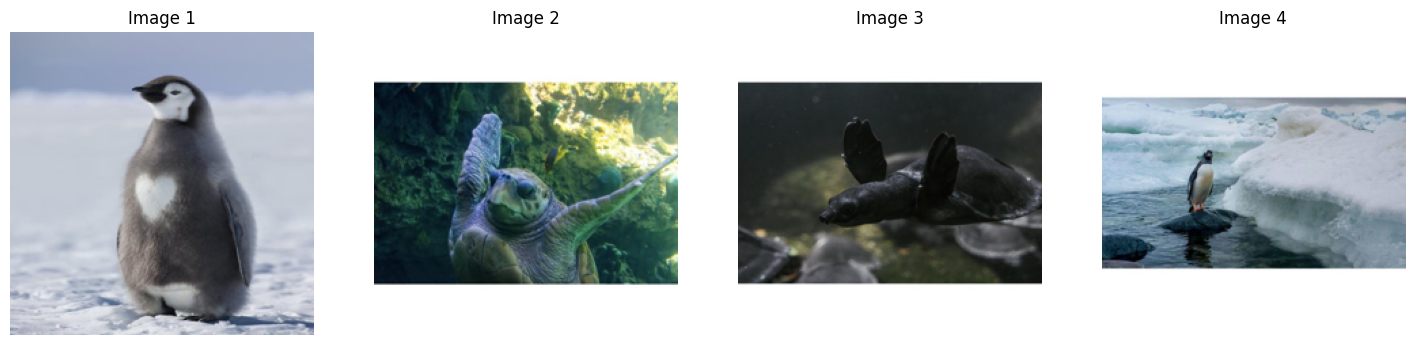

In [ ]:
example1 = val_images[0]
example2 = val_images[10]
example3 = val_images[39]
example4 = val_images[56]

example_list = [example1, example2, example3, example4]


# example heatmaps
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

for i in range(4):
    axes[i].axis('off')  # Turn off axis ticks and labels
    axes[i].set_title(f'Image {i+1}')
    axes[i].imshow(example_list[i])


plt.show()

In [ ]:
#GRAD CAM visualisation adapted from https://www.kaggle.com/code/ayuraj/gradcam-implementation-visualization-in-tf-w-b

#creating GRAD CAM heatmap
def make_gradcam_heatmap(img_array, model):
    # create model to extract prediction and output of last conv layer
    grad_model = keras.models.Model(
        model.inputs, [model.layers[2].output, model.output]
    )

    # calculate gradients of loss on last conv layer
    with tf.GradientTape() as tape:
        (last_conv_outputs, preds) = grad_model(img_array)
        loss = preds[0]
    grads = tape.gradient(loss, last_conv_outputs)

    #taking only positive gradients 
    conv_outputs_binary = tf.cast(last_conv_outputs > 0, "float32")
    grads_binary = tf.cast(grads > 0, "float32")
    guidedGrads = conv_outputs_binary * grads_binary * grads

    #removing a dimension
    last_conv_outputs = last_conv_outputs[0]
    guidedGrads = guidedGrads[0]

    #Computing weights of each feature map
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    
    #Creating heatmap by taking sum of importance of each feature 
    heatmap = tf.reduce_sum(tf.multiply(weights, last_conv_outputs), axis=-1)
    
    #resizing heatmap to match image
    heatmap = cv2.resize(heatmap.numpy(), (img_array.shape[2], img_array.shape[1]))
    #normalising and converting to uint8
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    heatmap = np.uint8(heatmap*255)

    return heatmap


In [ ]:
#overlaying heatmap on image
def overlay_gradcam(heatmap, image):
    heatmap_converted = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    image = np.uint8(image * 255)
    output = cv2.addWeighted(image, 0.5, heatmap_converted, 0.5, 0)
    return output


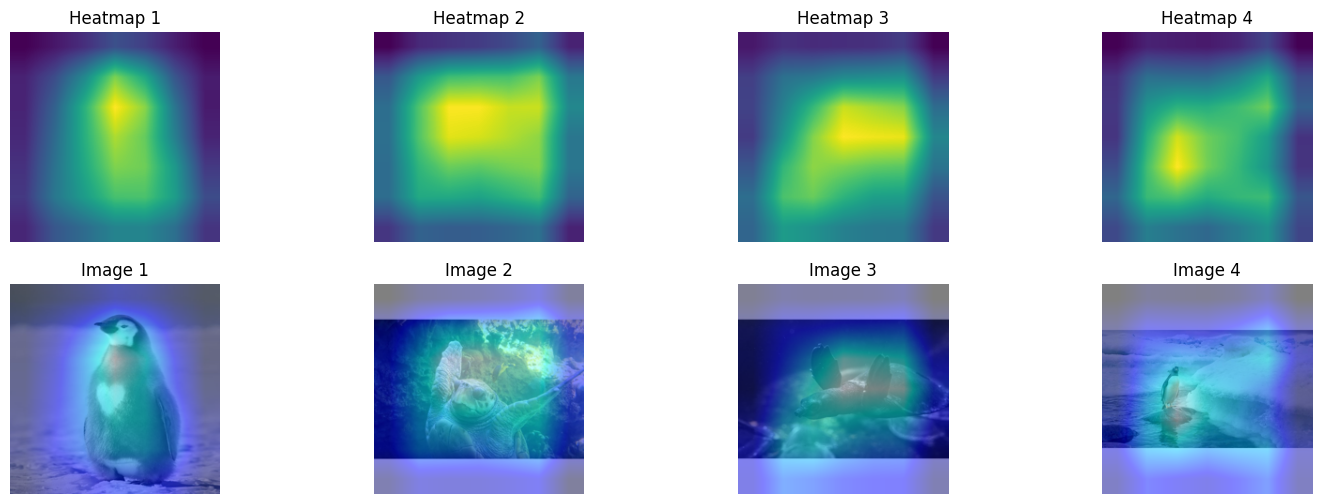

In [ ]:
#showing heatmaps overlaid on images 
heatmap_list = []
overlay_list = []
for i in range(4):
    heatmap_list.append(make_gradcam_heatmap(np.expand_dims(example_list[i], axis=0), cbam_model))
    overlay_list.append(overlay_gradcam(heatmap_list[i], example_list[i]))


# example heatmaps
fig, axes = plt.subplots(2, 4, figsize=(18, 6))
for i in range(4):
    axes[1][i].axis('off')  # Turn off axis ticks and labels
    axes[1][i].set_title(f'Image {i+1}')
    axes[1][i].imshow(overlay_list[i])
for i in range(4):
    axes[0][i].axis('off')  # Turn off axis ticks and labels
    axes[0][i].set_title(f'Heatmap {i+1}')
    axes[0][i].imshow(heatmap_list[i])